In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

### Importing Libraries

In [2]:
import pandas as pd

In [3]:
Train = pd.read_csv("train_processed.csv")
Test  = pd.read_csv("test_processed.csv")

In [4]:
Train.head()

,OriginalTweet,Sentiment
0,menyrbie philgahan chrisitv httpstcoifzfanpa a...,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,me ready to go at supermarket during the covid...,Extremely Negative


### Splitting in Train/Test Data/Target

In [5]:
import numpy as np

In [6]:
X_train = np.array(Train['OriginalTweet'])
Y_train = np.array(Train["Sentiment"])

In [7]:
X_test = np.array(Test['OriginalTweet'])
Y_test = np.array(Test["Sentiment"])

### Tokenization

In [8]:
from keras.preprocessing.text import Tokenizer

In [9]:
# Tokenizing Train Data
tokenizer_inputs_train = Tokenizer(filters = '')
tokenizer_inputs_train.fit_on_texts(X_train)
Train_data = tokenizer_inputs_train.texts_to_sequences(X_train)

In [10]:
# Tokenizing Test Data
tokenizer_inputs_test = Tokenizer(filters = '')
tokenizer_inputs_test.fit_on_texts(X_test)
Test_data = tokenizer_inputs_test.texts_to_sequences(X_test)

### Padding

In [11]:
from keras.preprocessing.sequence import pad_sequences

In [12]:
Train_data = pad_sequences(Train_data, maxlen=65, padding ='post')
print("encoder_data.shape:", Train_data.shape)

encoder_data.shape: (41155, 65)


In [13]:
Test_data = pad_sequences(Test_data, maxlen=65, padding ='post')
print("encoder_data.shape:", Test_data.shape)

encoder_data.shape: (3798, 65)


### One-hot Encoding

#### Converting in Intergers

In [14]:
Word2Int = {'Positive' : 0,
            'Extremely Positive' : 1,
            'Neutral' : 2,
            'Negative' : 3,
            'Extremely Negative' : 4}

In [15]:
for i in Train.index:
    Y_train[i] = (Word2Int[Y_train[i]])

In [16]:
for i in Test.index:
    Y_test[i] = (Word2Int[Y_test[i]])

#### One-Hot

In [17]:
from keras.utils import to_categorical

In [18]:
Y_train = to_categorical(Y_train)

In [19]:
Y_test = to_categorical(Y_test)

### Loading Pre-trained word vectors

In [20]:
import numpy as np

In [21]:
word2vec = {}                                                     # Dictionary for word 2 vector mapping
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()                                     # Reading Line
        word = values[0]                                          # First part of line is word
        vec = np.asarray(values[1:], dtype='float32')             # Second part of line is Vector
        word2vec[word] = vec                                      # Creating dictionary

### Preparing Embedding Matrix

In [22]:
# Total number of unique word in input seq
word2idx_inputs = tokenizer_inputs_train.word_index
print ("Number of unique words found: ", len(word2idx_inputs))

Number of unique words found:  94066


In [23]:
num_words = len(word2idx_inputs) + 1                         
embedding_matrix = np.zeros((num_words, 100))
for word, i in word2idx_inputs.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [24]:
embedding_matrix.shape

(94067, 100)

### Building Model

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPool1D

In [26]:
vocab_size = len(tokenizer_inputs_train.word_index) + 1

In [42]:
model = Sequential()
model.add(Embedding(input_dim = 94067, output_dim = 100, input_length=65, weights = [embedding_matrix], trainable = False))
model.add(Bidirectional(LSTM(256,return_sequences=True), merge_mode = 'concat'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.4))
model.add(Dense(65, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense((5), activation="softmax"))

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 65, 100)           9406700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 65, 512)           731136    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 65)                33345     
_________________________________________________________________
dropout_5 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

### Compiling the Model

In [44]:
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

### Training the Model

In [45]:
history = model.fit(Train_data, Y_train, validation_split=0.2, epochs=10, batch_size=64)

Epoch 1/10
515/515 [==============================] - 57s 110ms/step - loss: 1.3773 - accuracy: 0.3876 - val_loss: 1.1499 - val_accuracy: 0.5042
Epoch 2/10
515/515 [==============================] - 56s 109ms/step - loss: 1.1488 - accuracy: 0.5141 - val_loss: 1.0214 - val_accuracy: 0.5768
Epoch 3/10
515/515 [==============================] - 56s 109ms/step - loss: 1.0532 - accuracy: 0.5659 - val_loss: 0.9910 - val_accuracy: 0.5880
Epoch 4/10
515/515 [==============================] - 56s 109ms/step - loss: 0.9880 - accuracy: 0.6021 - val_loss: 0.9142 - val_accuracy: 0.6373
Epoch 5/10
515/515 [==============================] - 56s 109ms/step - loss: 0.9322 - accuracy: 0.6280 - val_loss: 0.8692 - val_accuracy: 0.6571
Epoch 6/10
515/515 [==============================] - 56s 109ms/step - loss: 0.8796 - accuracy: 0.6558 - val_loss: 0.8437 - val_accuracy: 0.6682
Epoch 7/10
515/515 [==============================] - 56s 110ms/step - loss: 0.8402 - accuracy: 0.6738 - val_loss: 0.8390 - val_ac

### Saving the Model

In [46]:
model.save('Bidirectional_sentiment_analysis.h5')

### Vizualizing the Results

In [47]:
import matplotlib.pyplot as plt

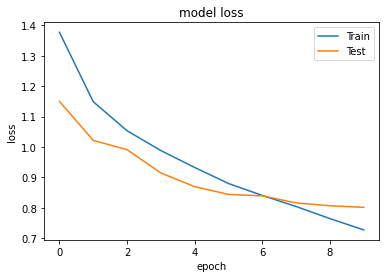

In [48]:
#Loss Graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('Loss')
plt.show()

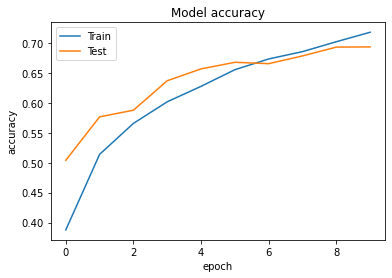

In [49]:
#Accuracy Graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Accuracy')
plt.show()